In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import json
import os

In [2]:
df = pd.read_csv('train.csv')

In [3]:
### Funciones Auxiliares ###

def densidad_plot_comparativo(df, tipos, columna, caracteristica):
    for col in tipos: 
        sns.distplot(df[df[columna] == col][caracteristica].dropna(), hist = False, label = col)
    plt.ylabel('Densidad')
    plt.title(f'Distribucion de {caracteristica} para diferentes tipos de propiedad')

def definir_zona(lat):
    if lat >= 25:
        return 'Norte'
    if lat < 20:
        return 'Sur'
    if 20 < lat < 25:
        return 'Centro'
    return np.nan

def min_threshold(df, threshold):
    '''Funcion para filtrar por una minima cantidad de datos'''
    return df["ciudad"].count() > threshold

def generar_scatter(df,zona):
    #plt.figure(figsize = (16,6))
    for año in range(2012,2017):
        nuevo_df = pd.DataFrame()
        info = df.loc[lambda x:(x['año_publicacion'] == año)]\
                                            .groupby(['mes_publicacion','año_publicacion'])
        info = info.agg({'precio':'sum', 'metroscubiertos':'sum', 'mes_publicacion':'count'})
        plt.scatter(info['mes_publicacion'],info['precio']/info['metroscubiertos'], label = año)
        plt.ylabel('Precio')
        plt.xlabel('Cantidad de publicaciones por mes')
        plt.title(f'Relacion oferta/precio por metro cuadrado promedio para zona {zona}')
        plt.legend(loc = 'lower right')
    plt.tight_layout()
    plt.savefig(f'./figs/scatter_oferta_precio_zona_{zona}.jpg')

def barplot_para_no_bools_zonal(df, categoria):
    aux = df.groupby(['zona', categoria]).agg({'precio':'sum', 'metroscubiertos':'sum'})
    aux['promedio_precio_metro_cubierto'] = aux['precio']/aux['metroscubiertos']
    ax = sns.barplot(x = 'zona', y = 'promedio_precio_metro_cubierto', hue = categoria, order = ['Norte', 'Centro', 'Sur'], data = aux.reset_index())
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    plt.title(f'Precio promedio por metro cubierto\n para una cantidad de {categoria} segun zona')
    plt.xlabel('')
    plt.ylabel('Precio')
    plt.savefig(f'./figs/{categoria}-Metrocubierto-Precio barplot.jpg')

def get_frequency(palabras):
    spanish_stemmer = SnowballStemmer('spanish')

    distancias = {}
    apariciones = {}

    for palabra in palabras:
        raiz = spanish_stemmer.stem(palabra)
        distancias[raiz] = distancias.get(raiz,{}) #get_closest_word(raiz, distances.get(stemmed_word, palabra), palabra)
        distancias[raiz][palabra] = distancias[raiz].get(palabra, 0) + 1
        apariciones[raiz] = apariciones.get(raiz, 0) + 1
    
    representantes = {}
    for raiz in apariciones:
        representantes[raiz] = max(list(distancias[raiz].items()), key = lambda x:x[1])[0]
              
    return {representantes[raiz]:apariciones[raiz] for raiz in distancias}

def get_descripciones_como_texto(df):
    palabras = []
    for texto in list(df['descripcion']):
        texto = str(texto)
        for palabra in texto.split():
            aux = ''
            for letra in palabra:
                if letra.isalpha():
                    aux+=letra
            if aux:
                palabras.append(aux)
    return palabras


# Setup

In [4]:
df["fecha_publicacion"] = pd.to_datetime(df["fecha"])
df["año_publicacion"] = df["fecha_publicacion"].dt.year
df["mes_publicacion"] = df["fecha_publicacion"].dt.month

# Wordcloud (Descripciones)

In [5]:
df_wc = df[['descripcion']]

## Filtrado de palabras

In [6]:
stop_words_sp = set(stopwords.words('spanish'))
stop_words_en = set(stopwords.words('english'))
stopwords = stop_words_sp | stop_words_en
stopwords.add('para')
spanish_stemmer = SnowballStemmer('spanish')
stopwords = set(map(spanish_stemmer.stem, stopwords))

palabras = get_palabras_descripciones(df)

if not os.path.isfile('wordcloud.json'): # Evito que se generen las frecuencias si ya estan cargadas en el archivo de wordcloud
    frecuencias = get_frequency(palabras)
    with open('wordcloud.json', 'w') as f:
        f.write(json.dumps(frecuencias))

with open('wordcloud.json') as f:
    frecuencias = json.loads(f.read())
    
palabras_filtradas = dict(filter(lambda k:spanish_stemmer.stem(k[0].lower()) not in stopwords, frecuencias.items()))

## Wordcloud base

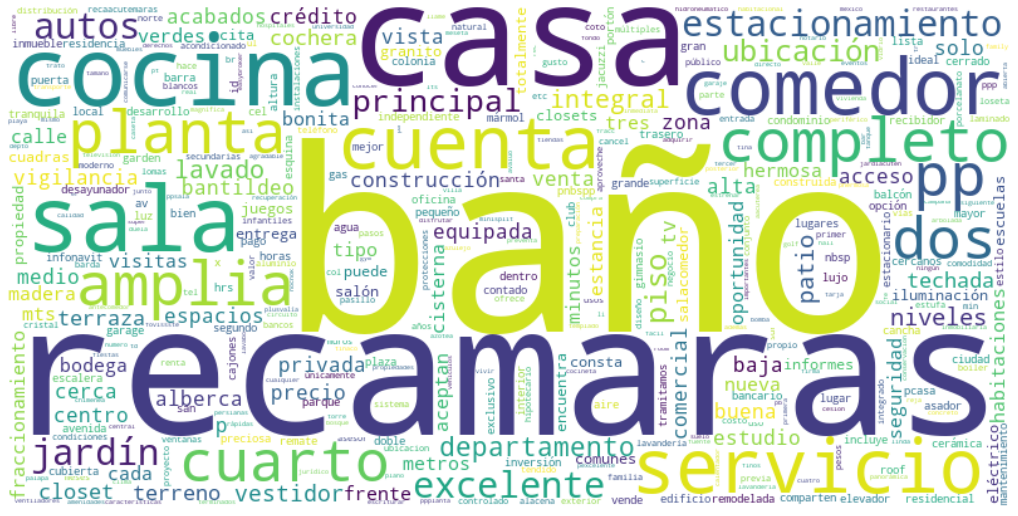

In [7]:
wordcloud = WordCloud(width=800,height=400, max_words=400, background_color="white").generate_from_frequencies(palabras_filtradas)
plt.figure(figsize=(18,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('./figs/wordcloud_basica.png')
plt.show()

## Wordcloud bandera

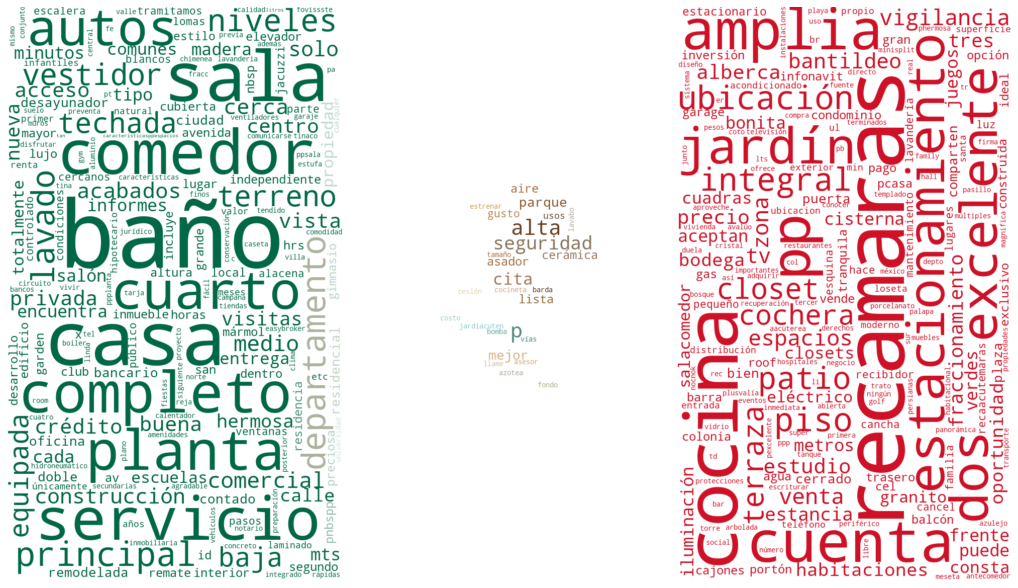

In [8]:
mask = np.array(Image.open("mexico.png"))
wordcloud = WordCloud(width=800,height=400, max_words=400, mode="RGBA", background_color="white", mask = mask).generate_from_frequencies(palabras_filtradas)
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(18,12))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.savefig('./figs/wordcloud_mexico.png')
plt.show()

# Distribuciones

## Antiguedad

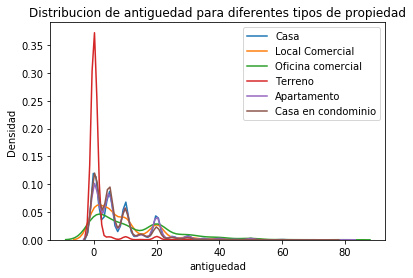

In [9]:
tipos_comunes = ['Casa', 'Local Comercial', 'Oficina comercial', 'Terreno', 'Apartamento', 'Casa en condominio']
densidad_plot_comparativo(df, tipos_comunes, 'tipodepropiedad', 'antiguedad')
plt.savefig('./figs/distribucion_antiguedad_2.png')

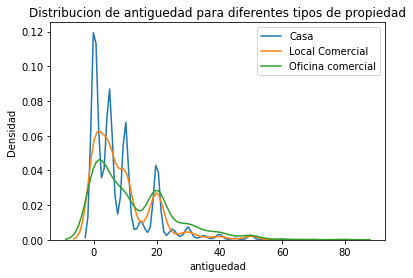

In [10]:
tipos_comunes = ['Casa', 'Local Comercial', 'Oficina comercial']
densidad_plot_comparativo(df, tipos_comunes, 'tipodepropiedad', 'antiguedad')
plt.savefig('./figs/distribucion_antiguedad_1.png')

## Precio

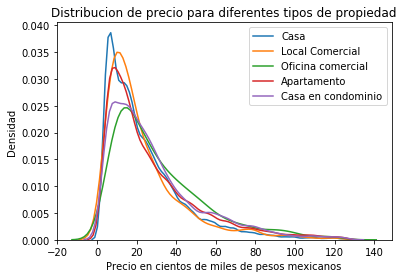

In [11]:
tipos_comunes.append('Apartamento')
tipos_comunes.append('Casa en condominio')
precios = df['precio'].copy()
df['precio'] = df['precio'].transform(lambda x:x/100000)
densidad_plot_comparativo(df, tipos_comunes, 'tipodepropiedad', 'precio')
df['precio'] = precios
plt.xlabel('Precio en cientos de miles de pesos mexicanos')
plt.savefig('./figs/distribucion_precios.png')
plt.show()

# Tiempo

In [12]:
fechas = df.groupby(['año_publicacion', 'mes_publicacion']).agg({'mes_publicacion': 'size'})
fechas = fechas.rename(columns = {'mes_publicacion':'publicaciones'})
fechas = fechas.reset_index().pivot(index="año_publicacion", columns = "mes_publicacion", values = "publicaciones")
fechas = fechas.T
for año in fechas.columns:
    fechas[año]/=fechas[año].sum()

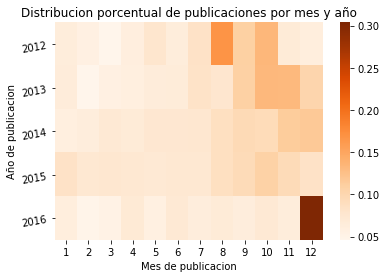

In [13]:
ax = sns.heatmap(fechas.T, cmap="Oranges")
ax.set_yticklabels(ax.get_yticklabels(), rotation=10)
plt.title("Distribucion porcentual de publicaciones por mes y año")
plt.xlabel("Mes de publicacion")
plt.ylabel("Año de publicacion")
ax.set_ylim(5.0, 0)
plt.savefig("figs/heatmap_fechas.png")
plt.show()

In [14]:
diciembre = df.loc[lambda x:(x['año_publicacion'] == 2016) & (x['mes_publicacion'] == 12), ['fecha_publicacion','id']]
diciembre['dia']=diciembre['fecha_publicacion'].dt.day
diciembre = diciembre.groupby('dia').count().reset_index()
diciembre.rename(columns = {'id':'publicaciones'}, inplace = True)

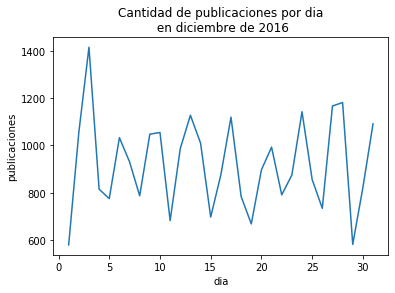

In [15]:
sns.lineplot(x = diciembre['dia'], y = diciembre['publicaciones'])
plt.title('Cantidad de publicaciones por dia\n en diciembre de 2016')
plt.savefig('./figs/diciembre_2016.png')

# Metros cubiertos

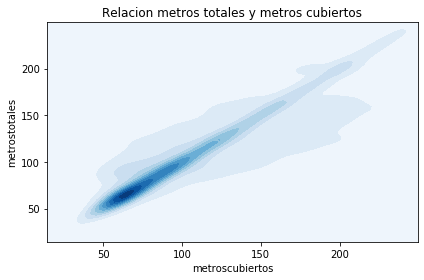

In [16]:
df2 = df.dropna(subset = ['metroscubiertos','metrostotales'])
metros = df2.loc[(df['metroscubiertos'] < 250) & (df['metrostotales'] < 250),]
m_totales = metros['metrostotales']
m_cubiertos = metros['metroscubiertos']
sns.kdeplot(m_cubiertos, m_totales, cmap="Blues", shade=True, bw=.15)
plt.title('Relacion metros totales y metros cubiertos')
plt.tight_layout()
plt.savefig('./figs/densidad_metroscubierto_con_metrostotales.png')

# Zonas

## Setup

In [17]:
zonas = df.set_index('ciudad')['lat'].transform(definir_zona)
aux = df.loc[:,['ciudad']]
aux['zona'] = df['lat'].transform(definir_zona)
aux['cant'] = 1

df2 = aux.groupby(['ciudad','zona']).agg({'cant':'count'}).reset_index()
df2 = df2[df2.groupby('ciudad')['cant'].transform('max') == df2['cant']].loc[:,['ciudad','zona']].set_index('ciudad')

df_zonas = df2.merge(df, on = 'ciudad', how = 'inner')
sin_diciembre = df_zonas.loc[lambda x:(x['año_publicacion'] != 2016) | (x['mes_publicacion'] != 12), ['mes_publicacion','año_publicacion','zona','precio','metroscubiertos']]

df2 = df_zonas.loc[lambda x:(x['año_publicacion'] != 2016) | (x['mes_publicacion'] != 12),]
evolucion_zonal = df2.groupby(['año_publicacion', 'mes_publicacion','zona']).agg({'id':'count'}).reset_index()
evolucion_por_zona = [evolucion_zonal.loc[evolucion_zonal['zona'] == 'Norte',]['id'],\
                      evolucion_zonal.loc[evolucion_zonal['zona'] == 'Centro',]['id'],\
                      evolucion_zonal.loc[evolucion_zonal['zona'] == 'Sur',]['id']]

## Precios

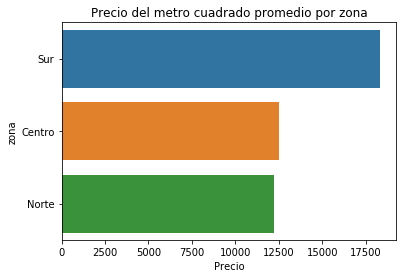

In [18]:
precio_zonal = df_zonas.groupby('zona').agg({'precio':'sum', 'metroscubiertos':'sum', 'id':'count'})
precio_zonal['promedio_precio_metro_cubierto'] = precio_zonal['precio']/precio_zonal['metroscubiertos']
sns.barplot(y = 'zona', x = 'promedio_precio_metro_cubierto', \
            data = precio_zonal.reset_index()\
                               .sort_values(by='promedio_precio_metro_cubierto', ascending = False))
plt.title('Precio del metro cuadrado promedio por zona')
plt.xlabel('Precio')
plt.savefig('./figs/precio_metro_cubierto_zonal.png')

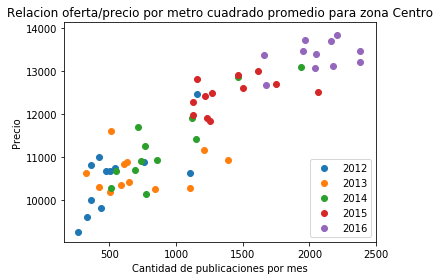

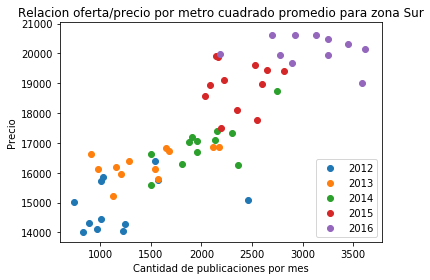

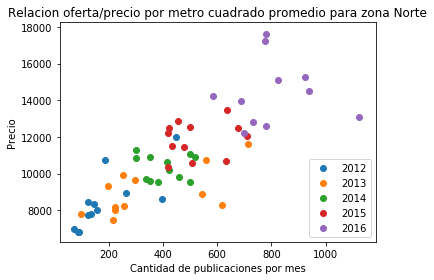

In [19]:
for zona in sin_diciembre['zona'].unique():
    generar_scatter_zonal_oferta(sin_diciembre.loc[lambda x:x['zona'] == zona,], zona)
    plt.show()

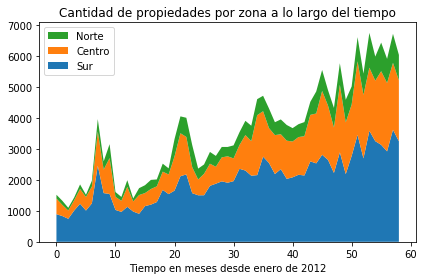

In [20]:
fig, ax = plt.subplots()
ax.stackplot(range(59), evolucion_por_zona[::-1] ,labels = evolucion_zonal['zona'].unique())
plt.title('Cantidad de propiedades por zona a lo largo del tiempo')
handles, labels = ax.get_legend_handles_labels()
order = [2,1,0]
plt.legend([handles[idx] for idx in order],['Norte', 'Centro', 'Sur'], loc = 'upper left')
plt.xlabel('Tiempo en meses desde enero de 2012')
plt.tight_layout()
fig.savefig('./figs/Evolucion_cantidad_de_publicaciones_zonal_tiempo.png')
plt.show()

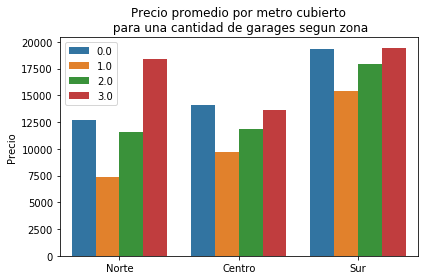

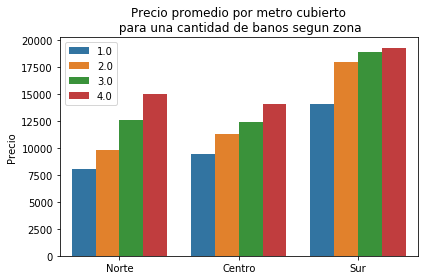

In [21]:
for tipo in ['garages', 'banos']:
    barplot_para_no_bools_zonal(df_zonas, tipo)
    plt.tight_layout()
    plt.savefig(f'./figs/precio_{tipo}_zonal.png')
    plt.show()